<a href="https://colab.research.google.com/github/tg-bomze/NeuralStockPredictor/blob/master/NeuralStockPredictor_Rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><font color="red" size="+3">NeuralStockPredictor

---

*↓ Открой меня ↓*

##**Краткая инструкция:**

Для запуска нажмите **Open in playground** в верхнем левом углу:

![alt text](https://d.radikal.ru/d39/2001/c1/4192dfd3a667.jpg)

(*на предложение reset runtime отвечать утвердительно*)

Далее, нажав на квадратные скобки выполняйте каждый блок поочередно, дожидаясь окончания выполнения предыдущего (*картинка представлена в качестве примера*):

![alt text](https://d.radikal.ru/d18/2001/1a/b618f3778f86.jpg)

*Блок считается выполненным, когда вокруг квадратных скобок* **[**_**]** *перестанет бегать "змейка"*

##**Исследование провел:**
GitHub: [@tg-bomze](https://github.com/tg-bomze)

Telegram: [@bomze](https://t.me/bomze) 

Twitter: [@tg_bomze](https://twitter.com/tg_bomze)

# <b><font color="red" size="+2">Исследование:

Прогнозирование цены акций с использованием сверточных и рекуррентных нейронных сетей на Keras

In [1]:
#@title <b><font color="gree" size="+2">Устанавливаем необходимые библиотеки {display-mode: "form"}
%%time
!pip install imgaug==0.2.5
!pip install scipy==1.2
!pip install talos
!pip install --upgrade yfinance

from IPython.display import clear_output

import plotly 
import plotly.graph_objects as go

import matplotlib
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import tensorflow as tf
import yfinance as yf
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import talos as ta
import math
import time
import sys
import os

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import mean_squared_error, roc_auc_score, r2_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from talos.utils.gpu_utils import parallel_gpu_jobs
from talos.model.normalizers import lr_normalizer
from matplotlib.dates import bytespdate2num
from google.colab import files
from matplotlib import style
from time import time

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers import Embedding, Input, SpatialDropout1D, AtrousConvolution1D
from keras.layers import GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.optimizers import RMSprop, Adam, SGD, Nadam, Adamax
from keras.utils import plot_model, np_utils, to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.advanced_activations import *
from keras.initializers import *
from keras.constraints import *
from keras import backend as K
from keras import regularizers
from keras import losses

sns.despine()
%matplotlib inline
style.use('ggplot')
clear_output()

CPU times: user 3.34 s, sys: 845 ms, total: 4.18 s
Wall time: 1min 49s


In [2]:
#@title <b><font color="gree" size="+2">Объявляем основные переменные и загружаем исходные данные {display-mode: "form"}
#@markdown Размер входных данных (в днях).
WINDOW = 30   #@param {type:"slider", min:10, max:90, step:10}
EMB_SIZE = 8  # колич. входных перем.
#@markdown Размер тестовой выборки (в частях).
PERCENT = 0.9   #@param {type:"slider", min:0, max:1, step:0.05}
STEP = 1      # шаг
#@markdown Дальность предсказания (в днях).
FORECAST = 1   #@param {type:"slider", min:1, max:10, step:1}
#@markdown Курс какой акции будем предсказывать?
TICKER = 'GAZP.ME' #@param ["GAZP.ME", "SBER.ME", "ROSN.ME", "VTBR.ME", "TSLA", "GOOG", "AMZN", "FB"]
#@markdown Если в выпадающем списке вы не нашли необходимую вам акцию, то воспользуйтесь ручной загрузкой котировок. Данные предлагается скачивать с https://finance.yahoo.com. Просто введите в поиске необходимый вам тикер и скачайте csv-файл.
upload_stock_quotes = False #@param {type:"boolean"}
#@markdown Установленная галочка сверху предложит вам загрузить этот файл с вашей локальной машины.

if upload_stock_quotes == False:
  # --- Загружаем исторические данные тикер ---
  tic = yf.Ticker(TICKER)
  data_original = tic.history(period="max")
  # -------------------------------------------
  # заменяем пустые данные нулем
  data_original = data_original.fillna(0)
  # удаляем те строки, когда данных по торгам небыло
  data_original = data_original.loc[data_original['Volume'] > 0]
  # удаляем столбцы, по которым небыло данных
  del data_original['Dividends']
  del data_original['Stock Splits']
  # Вытаскиваем Дату из индекса
  data_original.reset_index(inplace=True)
  # создаем дополнительный датафрейм new_data для расчета результатов
  new_data = pd.DataFrame(np.sort(data_original['Date'], axis=0), columns=['Date'])
  # устанавливаем Дату как индекс обратно
  data_original = data_original.set_index('Date')
else:
  # --- Загружаем исторические данные тикер ---
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  TICKER = fn.split('.')[0]
  data_original = pd.read_csv('{}.csv'.format(TICKER))
  # -------------------------------------------
  # заменяем пустые данные нулем
  data_original.fillna(0)
  # удаляем те строки, когда данных по торгам небыло
  data_original = data_original.loc[data_original['Volume'] > 0]
  # создаем дополнительный датафрейм new_data для расчета результатов
  new_data = pd.DataFrame(np.sort(data_original['Date'], axis=0), columns=['Date'])
  # устанавливаем Дату как индекс
  data_original = data_original.set_index('Date')
  # удаляем лишний столбец
  del data_original['Adj Close']

clear_output()
fig = go.Figure(data=[go.Candlestick(x=data_original.index,
                open=data_original['Open'],
                high=data_original['High'],
                low=data_original['Low'],
                close=data_original['Close'])])

fig.update_layout(xaxis_rangeslider_visible=False)

fig.update_layout(
    title='Курс акции {}'.format(TICKER),
    yaxis_title='Цена',
    xaxis_title='Дни')

fig.show()

In [3]:
#@title <b><font color="gree" size="+2">Объявляем все функции для расчета дополнительных параметров {display-mode: "form"}
def simple_func(ishod):
  result_res = []
  for i in range(0,len(ishod)):
    result_res.append(ishod[i])
  return pd.DataFrame(result_res)

def find_result(ishod):
  # (1 - рост, 0 - падение)
  result_res = []
  result_res.append(0)
  for i in range(0,len(ishod)-1):
    result = 0 if ishod[0][i+1] < ishod[0][i] else 1
    result_res.append(result)
  return pd.DataFrame(result_res)

def shuffle_in_unison(a, b):
  assert len(a) == len(b)
  shuffled_a = np.empty(a.shape, dtype=a.dtype)
  shuffled_b = np.empty(b.shape, dtype=b.dtype)
  permutation = np.random.permutation(len(a))
  for old_index, new_index in enumerate(permutation):
    shuffled_a[new_index] = a[old_index]
    shuffled_b[new_index] = b[old_index]
  return shuffled_a, shuffled_b

def create_Xt_Yt(X, y, percentage=0.9):
  p = int(len(X) * percentage)
  X_train = X[0:p]
  Y_train = y[0:p]
  X_train, Y_train = shuffle_in_unison(X_train, Y_train)
  X_test = X[p:]
  Y_test = y[p:]
  return X_train, X_test, Y_train, Y_test

# --- Функция расчета гэпа ---
def find_gap(ishod):
  # разница между текущим открытием и предыдущим закрытием
  gap_res = []
  gap_res.append(0)
  for i in range(0,len(ishod)-1):
    gap = abs(ishod["Open"][i+1] - ishod["Close"][i])
    gap_res.append(gap)
  return pd.DataFrame(gap_res)

# --- Функция расчета (High-Low) ---
def find_hldif(ishod):
  # разница между максимумом и минимумом
  hldif_res = []
  for i in range(0,len(ishod)):
    hldif = (ishod["High"][i] - ishod["Low"][i])
    hldif_res.append(hldif)
  return pd.DataFrame(hldif_res)

# --- Функция расчета разницы двух экспоненциальных скользящих средних ---
def find_emad(ishod, fast, slow):
  # находим из двух параметров быстрый и медленный
  params = [fast,slow]
  params = pd.DataFrame(params)
  faster = int(params.min()) # период быстрой ЭкспСкользСредн
  slower = int(params.max()) # период медленной ЭкспСкользСредн
  # считаем медленную ЭкспСкользСредн
  alpha_slow = 2 / (slower + 1)
  sma_slow = []
  ema_slow = []
  for i in range(0,len(ishod)):
    smas = 0 if (i < (slower-1)) else ishod["Close"][i-(slower-1):i+1].mean()
    sma_slow.append(smas)
    if i < (slower-1):
      emas = 0
    elif i == (slower-1):
      emas = ishod["Close"][i-(slower-1):i+1].mean()
    else:
      emas = (alpha_slow * ishod["Close"][i]) + ((1 - alpha_slow)*ema_slow[i-1])
    ema_slow.append(emas)
  # считаем быструю ЭкспСкользСредн
  alpha_fast = 2 / (faster + 1)
  sma_fast = []
  ema_fast = []
  for i in range(0,len(ishod)):
    smaf = 0 if (i < (slower-1)) else ishod["Close"][i-(faster-1):i+1].mean()
    sma_fast.append(smaf)
    if i < (slower-1):
      emaf = 0
    elif i == (slower-1):
      emaf = ishod["Close"][i-(faster-1):i+1].mean()
    else:
      emaf = (alpha_fast * ishod["Close"][i]) + ((1 - alpha_fast)*ema_fast[i-1])
    ema_fast.append(emaf)
  emad_res = pd.DataFrame(ema_fast) - pd.DataFrame(ema_slow)
  return emad_res

# --- Функция расчета стохастического осциллятора ---
def find_stoch(ishod, k, smooth):
  # находим из двух параметров k и период сглаживания
  params = [k,smooth]
  params = pd.DataFrame(params)
  smooth_per = int(params.min()) # период сглаживания
  k_per = int(params.max()) # период k
  otstup = (k_per + smooth_per)-1 # необходимый отступ дней для анализа
  # считаем показатель k
  max_high = []
  min_low = []
  k_res = []
  for i in range(0,len(ishod)):
    high = 0 if (i < (k_per-1)) else ishod["High"][i-(k_per-1):i+1].max()
    low = 0 if (i < (k_per-1)) else ishod["Low"][i-(k_per-1):i+1].min()
    k_pokaz = 0 if (i < (k_per-1)) else (ishod["Close"][i] - low) / (high - low)
    max_high.append(high)
    min_low.append(low)
    k_res.append(k_pokaz) 
  # сглаживаем показатель k
  stoch_k = pd.DataFrame(k_res)
  stoch_res = []
  for i in range(0,len(ishod)):
    smooth_k = 0 if (i < (otstup-1)) else stoch_k[i-(smooth_per-1):i+1].mean()
    stoch_res.append(float(smooth_k))
  return pd.DataFrame(stoch_res)

# --- Функция расчета волатильности ---
def find_volat(ishod, period):
  # значение волатильности за определенный период
  volat_res = []
  for i in range(0,len(ishod)):
    volat = 0 if (i < (period-1)) else ishod["Close"][i-(period-1):i+1].std()
    volat_res.append(volat) 
  return pd.DataFrame(volat_res)

In [4]:
#@title <b><font color="gree" size="+2">Расчитываем дополнительные параметры и проводим нормализацию данных {display-mode: "form"}

#@markdown Период быстрой ЭкспСкользСредн
fast_emad = 8 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Период медленной ЭкспСкользСредн
slow_emad = 18 #@param {type:"slider", min:1, max:32, step:1}
#@markdown Период K для стохастического осциллятора
k_stoch = 5 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Период сглаживания для стохастического осциллятора
smooth_stoch = 3 #@param {type:"slider", min:1, max:8, step:1}
#@markdown Период расчета волатильности
period_volat = 6 #@param {type:"slider", min:1, max:16, step:1}
#@markdown Период автокорреляции
window_autocorr = 30 #@param {type:"slider", min:10, max:90, step:5}
#@markdown Лаг автокорреляции
lag_autocorr = 4 #@param {type:"slider", min:1, max:10, step:1}

data_original['log_ret'] = np.log(data_original['Close']).diff()
data_original['Autocorr'] = data_original['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, 
                                                             center=False).apply(lambda x: x.autocorr(lag=lag_autocorr), raw=False)
# заполняем расчетную таблицу
new_data['AUTCOR'] = simple_func(data_original['Autocorr'])
new_data['GAP'] = find_gap(data_original)
new_data['HLDIF'] = find_hldif(data_original)
new_data['CLOSE'] = simple_func(data_original['Close'])
new_data['VOLUME'] = simple_func(data_original['Volume'])
new_data['EMAD'] = find_emad(data_original, fast_emad, slow_emad)
new_data['STOCH'] = find_stoch(data_original, k_stoch, smooth_stoch)
new_data['VOLAT'] = find_volat(data_original, period_volat)
del data_original["log_ret"]
del data_original["Autocorr"]

# определяем количество удаляемых строк
lishnee = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1, window_autocorr+1, lag_autocorr]
lishnee = pd.DataFrame(lishnee)
row_del = int(lishnee.max())

# удаляем пустые строки
new_data = new_data[row_del-1:]
new_data.reset_index(inplace=True)
del new_data["index"]
# заменяем пустые данные нулем
new_data = new_data.fillna(0)

# --- Нормализация данных ---
min_max_scaler = preprocessing.MinMaxScaler()
new_data['GAP'] = min_max_scaler.fit_transform(new_data.GAP.values.reshape(-1,1))
new_data['HLDIF'] = min_max_scaler.fit_transform(new_data.HLDIF.values.reshape(-1,1))
new_data['CLOSE'] = min_max_scaler.fit_transform(new_data.CLOSE.values.reshape(-1,1))
new_data['VOLUME'] = min_max_scaler.fit_transform(new_data.VOLUME.values.reshape(-1,1))
new_data['EMAD'] = min_max_scaler.fit_transform(new_data.EMAD.values.reshape(-1,1))
new_data['STOCH'] = min_max_scaler.fit_transform(new_data.STOCH.values.reshape(-1,1))
new_data['VOLAT'] = min_max_scaler.fit_transform(new_data.VOLAT.values.reshape(-1,1))
new_data['AUTCOR'] = min_max_scaler.fit_transform(new_data.AUTCOR.values.reshape(-1,1))

gapn = new_data.loc[:, 'GAP'].tolist()
hldifn = new_data.loc[:, 'HLDIF'].tolist()
closen = new_data.loc[:, 'CLOSE'].tolist()
volumen = new_data.loc[:, 'VOLUME'].tolist()
emadn = new_data.loc[:, 'EMAD'].tolist()
stochn = new_data.loc[:, 'STOCH'].tolist()
volatn = new_data.loc[:, 'VOLAT'].tolist()
autocorn = new_data.loc[:, 'AUTCOR'].tolist()

gapn, hldifn, closen, volumen = gapn[WINDOW:], hldifn[WINDOW:], closen[WINDOW:], volumen[WINDOW:]
emadn, stochn, volatn, autocorn = emadn[WINDOW:], stochn[WINDOW:], volatn[WINDOW:], autocorn[WINDOW:]

# выводим сводные статистичекие данные по расчетной таблице new_data
new_data.describe()

,AUTCOR,GAP,HLDIF,CLOSE,VOLUME,EMAD,STOCH,VOLAT
count,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000,2573.000000
mean,0.504440,0.032235,0.032103,0.238695,0.128910,0.591640,0.510282,0.107841
std,0.176439,0.062700,0.073340,0.206070,0.111369,0.076678,0.257329,0.099185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.376999,0.007439,0.014305,0.118564,0.069037,0.556032,0.285937,0.051677
50%,0.502047,0.018066,0.019807,0.163262,0.105056,0.592989,0.505667,0.083121
75%,0.632832,0.034538,0.028702,0.262198,0.157495,0.624202,0.736629,0.126954
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
#@title <b><font color="gree" size="+2">Предподготовка данных к обучению нейронной сети {display-mode: "form"}

X, Y = [], []
for i in range(0, len(new_data), STEP): 
    try:
        g = gapn[i:i+WINDOW]
        h = hldifn[i:i+WINDOW]
        c = closen[i:i+WINDOW]
        v = volumen[i:i+WINDOW]
        e = emadn[i:i+WINDOW]
        s = stochn[i:i+WINDOW]
        b = volatn[i:i+WINDOW]
        a = autocorn[i:i+WINDOW]

        y_i = closen[i+WINDOW+FORECAST]  
        x_i = np.column_stack((g, h, c, v, e, s, b, a))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y, PERCENT)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

Изменение портфолио: 94.6 % за 252 дней


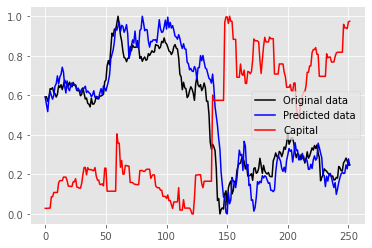

In [6]:
#@title <b><font color="gree" size="+2">Быстрый анализ (предсказание и бэктестинг) {display-mode: "form"}

#@markdown Размер первоначального капитала (в y.e.).
CAPITAL = 100000 #@param {type:"integer"}
#@markdown Доля капитала, на которую открываем ордер (в частях).
CHAST = 0.05 #@param {type:"slider", min:0.05, max:1, step:0.05}
#@markdown Размер комиссии за открытие/закрытие ордера (в %).
KOMISSIYA = 0.05 #@param {type:"slider", min:0, max:1, step:0.05}
KOMISSIYA = KOMISSIYA / 100

#@markdown Выберите предобученную модель для вашей акции
MODEL = 'GAZP' #@param ["GAZP", "SBER", "ROSN", "VTBR", "TSLA", "GOOG", "AMZN", "FB"]
#@markdown Если в выпадающем списке вы не нашли необходимую вам предобученную модель, то можете обучить ее самостоятельно.
new_training = False #@param {type:"boolean"}
#@markdown Если качество обученной модели окажется низким, поэтому предлагается пропустить этот блок и преступить к следующему.

if new_training == True:
  model = Sequential()
  model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(LeakyReLU())
  model.add(Conv1D(filters=32,kernel_size=4,padding='same'))
  model.add(MaxPooling1D(pool_size=3))
  model.add(LeakyReLU())
  model.add(LSTM(32,return_sequences=True))
  model.add(Flatten())
  model.add(Dense(16))
  model.add(LeakyReLU())
  model.add(Dropout(0.5))
  model.add(Dense(1))
  model.add(Activation('linear'))
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
  checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)
  model.compile(optimizer=Adam(lr=0.002), loss='mean_absolute_error')
  history = model.fit(X_train, Y_train, 
                epochs = 100, 
                batch_size = 256, 
                verbose=1, 
                validation_data=(X_test, Y_test),
                callbacks=[reduce_lr, checkpointer],
                shuffle=True)
else:
  if MODEL == 'GAZP':
    !gdown https://drive.google.com/uc?id=1LEFpCsKPK_LLvZDcs4exZ0hhQbUYgo7r
  elif MODEL == 'SBER':
    !gdown https://drive.google.com/uc?id=1V1LhIVUGLXUZ66ajbEpqwZvBiuCTQjba
  elif MODEL == 'ROSN':
    !gdown https://drive.google.com/uc?id=1XM6CcZVBstRTt9PEGnqaLmGw_87QNKOE
  elif MODEL == 'VTBR':
    !gdown https://drive.google.com/uc?id=19k4dOmq4gyQPbSwCMcX6d0lHSN3jXSYH
  elif MODEL == 'TSLA':
    !gdown https://drive.google.com/uc?id=1r5uYwTEiljCg4EBICk3kOFz2xI3FRQWK
  elif MODEL == 'GOOG':
    !gdown https://drive.google.com/uc?id=1NrfxLgei-lPCvNxJ6FRRPTlgj8W1l5W3
  elif MODEL == 'AMZN':
    !gdown https://drive.google.com/uc?id=1BO8Nv2LBnyf8RDwSkzDcV-dWIpd21D3i
  elif MODEL == 'FB':
    !gdown https://drive.google.com/uc?id=1ewHlSXJEZZkFFVaa6hxGIdVBV6D2ZXno
  !unzip -u model.zip
  model = load_model("model.h5")
  model.load_weights("weights.h5")
  !rm model.zip
  !rm weights.h5
  !rm model.h5

pred = model.predict(X_test)
predicted = pred
original = Y_test

data_original.reset_index(inplace=True) # Вытаскиваем Дату из индекса
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date') # устанавливаем Дату как индекс обратно
test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))
backtest = pd.concat([test_dates, test_price, test_signal], axis=1)
backtest.columns = (['Date', 'Price', 'Signal'])

balans = []
balans.append(CAPITAL)
capital_now = CAPITAL
signal_now = backtest['Signal'][0]
price_now = backtest['Price'][0]
change_now = 0.0

for i in range(1,len(backtest)): # перебираем все сигналы
  if signal_now == backtest['Signal'][i]: # если текущий сигнал совпадает с изначальным, тогда
    balans.append(capital_now) # ничего не меняем и переписываем текущий капитал
  else: # если же сигнал поменялся, то
    change_now = (backtest['Price'][i] - price_now) / price_now # считаем изменение цены
    if signal_now > 0.5: # если изначально был сигнал на рост
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total + (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA # считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену      
    else: # если сигнал был на падение
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total - (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA # считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену

backtest['Capital'] = pd.DataFrame(balans)
from IPython.display import clear_output
clear_output()

orig = pd.DataFrame(original)
perd = pd.DataFrame(predicted)
capi = pd.DataFrame(np.array(backtest['Capital']))
itog = pd.concat([orig, perd, capi], axis=1)
itog.columns = (['orig', 'perd', 'capi'])
itog['orig'] = min_max_scaler.fit_transform(itog.orig.values.reshape(-1,1))
itog['perd'] = min_max_scaler.fit_transform(itog.perd.values.reshape(-1,1))
itog['capi'] = min_max_scaler.fit_transform(itog.capi.values.reshape(-1,1))
print("Изменение портфолио:", round((itog['capi'][len(itog['capi'])-1] - itog['capi'][0])*100, 1),"% за", len(itog['capi']), "дней")
plt.plot(itog['orig'], color = 'black', label = 'Original data')
plt.plot(itog['perd'], color = 'blue', label = 'Predicted data')
plt.plot(itog['capi'], color = 'red', label = 'Capital')
plt.legend()
plt.show()

## <b><font color="gree" size="+2">Основной анализ (ручная настройка)

Ниже в разделах "***Строим архитектуру сети***" и "***Обучаем нейросеть***" будет предложено вручную настроить весь процесс обучения нейронной сети. Помимо этого можно будет также загрузить архитектуру и веса сети, которые можно взять [**ТУТ**](https://drive.google.com/open?id=1ln7tEV5YQf-imL7DzoyLIU2BfoP1PqIF).

### <b><font color="black" size="+1">Строим архитектуру сети

**Если хотите воспользоваться готовой архитектурой, то можно загрузить файл model.h5**

In [ ]:
# --- Загружаем файл на сервер ---
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# --------------------------------

model = load_model("model.h5")
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

**Если нет, то строим самостоятельно**

In [ ]:
'''# --- Новая версия ---
model= Sequential()
model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(LeakyReLU())
model.add(Conv1D(filters=32,kernel_size=4,padding='same'))
model.add(MaxPooling1D(pool_size=3))
model.add(LeakyReLU())
model.add(LSTM(64,return_sequences=True))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dropout(0.7))
model.add(Dense(1))
model.add(Activation('linear'))
# --------------------'''

# --- Старая версия (стабильная) ---
model = Sequential()
model.add(Conv1D(input_shape = (WINDOW, EMB_SIZE),filters=16,kernel_size=4,padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Conv1D(filters=64,kernel_size=4,padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU())
model.add(Dense(1))
model.add(Activation('linear'))
# ---------------------

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error') # mean_absolute_error, mean_squared_error

model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

### <b><font color="black" size="+1">Обучаем нейросеть

**Если хотите воспользоваться уже обученной сетью, то можно загрузить файл файл с весами weights.h5**

In [ ]:
# --- Загружаем файл на сервер ---
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
# --------------------------------

model.load_weights("weights.h5")
pred = model.predict(X_test)
predicted = pred
original = Y_test

**Если нет, то обучаем самостоятельно**

In [ ]:
start = time()
history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 256, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)
finish = time()

**Сохраняем результаты предсказания**

In [ ]:
print("Затрачено секунд:", finish - start)
pred = model.predict(X_test)
predicted = pred
original = Y_test

Затрачено секунд: 5.736419916152954


**Визуализация результата**

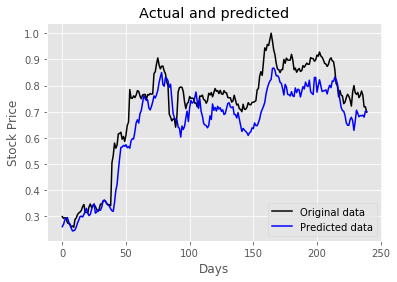

In [ ]:
plt.title('Actual and predicted')
plt.plot(original, color = 'black', label = 'Original data')
plt.plot(predicted, color = 'blue', label = 'Predicted data')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

### <b><font color="black" size="+1">Оценка точности модели

In [ ]:
predic = pd.DataFrame(predicted)
fact = pd.DataFrame(original)
itog = pd.concat([predic, fact], axis=1)
itog.columns = (['pred', 'fact'])
itog["predUD"] = find_result(predic)
itog["factUD"] = find_result(fact)

true_long = 0
true_short = 0
vern = 0

for i in range(0,len(itog)):
  if itog["predUD"][i] > 0.5 and itog["factUD"][i] > 0.5:
    true_long = true_long + 1
  elif itog["predUD"][i] < 0.5 and itog["factUD"][i] < 0.5:
    true_short = true_short + 1
  
  if itog["predUD"][i] == itog["factUD"][i]:
    vern = vern + 1
    
per_long = round((true_long/len(itog[itog["factUD"]>0.5]))*100,2)
per_short = round((true_short/len(itog[itog["factUD"]<0.5]))*100,2)
per_vern = round((vern/len(itog))*100,2)

print("Процент вырных ордеров на повышение:", per_long)
print("Процент верный ордеров на понижение:", per_short)
print("")
print("Процент верных прогнозов:", per_vern)
print("--------------------------------------")
itog.head()

# для перебора каждых вторых данных нужно удалить "2" из строк:
# for i in range(0,len(itog),2):
# print("Процент вырных ордеров на повышение:", per_long*2)
# print("Процент верный ордеров на понижение:", per_short*2)
# print("Процент верных прогнозов:", per_vern*2)

Процент вырных ордеров на повышение: 56.3
Процент верный ордеров на понижение: 55.37

Процент верных прогнозов: 55.83
--------------------------------------


,pred,fact,predUD,factUD
0,0.260672,0.298881,0,0
1,0.269898,0.291848,1,0
2,0.286241,0.295089,1,1
3,0.291665,0.292704,1,0
4,0.295423,0.275579,1,0


In [ ]:
print ("MSE =", np.mean(np.square(predicted - original)))
print ("MAE =", np.mean(np.abs(predicted - original)))
print ("MAPE =", np.mean(np.abs((original - predicted) / original)))

MSE = 0.07131233666676697
MAE = 0.2025770944113796
MAPE = 0.35941051355341186


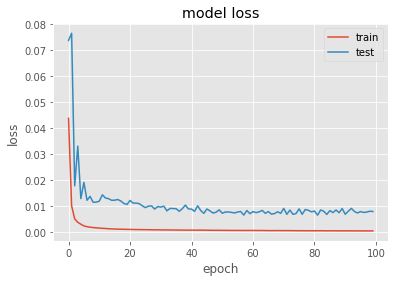

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

### <b><font color="black" size="+1">Бэктестинг инструмента

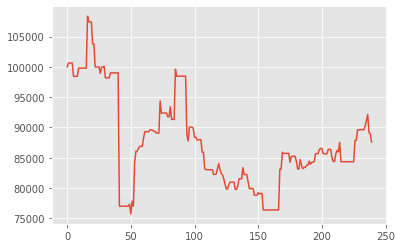

In [ ]:
data_original.reset_index(inplace=True) # Вытаскиваем Дату из индекса
test_dates = pd.DataFrame(np.array(data_original["Date"][-len(Y_test):]))
test_price = pd.DataFrame(np.array(data_original["Close"][-len(Y_test):]))
data_original = data_original.set_index('Date') # устанавливаем Дату как индекс обратно
test_signal = pd.DataFrame(np.array(find_result(pd.DataFrame(pred))))
backtest = pd.concat([test_dates, test_price, test_signal], axis=1)
backtest.columns = (['Date', 'Price', 'Signal'])

CAPITAL = 100000.0 # размер первоначального капитала
CHAST = 1 # 0.05 = 5% доля капитала, на которую открываем ордер
KOMISSIYA = 0.0005 # 0.0005 = 0.05% комиссия за открытие/закрытие ордера

balans = []
balans.append(CAPITAL)
capital_now = CAPITAL
signal_now = backtest['Signal'][0]
price_now = backtest['Price'][0]
change_now = 0.0

for i in range(1,len(backtest)): # перебираем все сигналы
  if signal_now == backtest['Signal'][i]: # если текущий сигнал совпадает с изначальным, тогда
    balans.append(capital_now) # ничего не меняем и переписываем текущий капитал
  else: # если же сигнал поменялся, то
    change_now = (backtest['Price'][i] - price_now) / price_now # считаем изменение цены
    if signal_now > 0.5: # если изначально был сигнал на рост
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total + (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA # считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену      
    else: # если сигнал был на падение
      #-------------------------------
      total = capital_now * CHAST # считаем сумму для открытия ордера
      capital_now = capital_now - total # при открытии отнимаем эту сумму от капитала
      komis_open = total * KOMISSIYA # считаем комиссию за открытие сделки
      total = total - (total * change_now) # расчитываем сумму с учетом изменения цены актива
      komis_close = total * KOMISSIYA# считаем комиссию за закрытие сделки
      total = total - komis_open - komis_close # считаем сумму за вычетом комиссий
      capital_now = capital_now + total # при закрытии ордера прибавляем сумму от капитала
      balans.append(capital_now) # и переписываем текущий капитал
      #-------------------------------
      signal_now = backtest['Signal'][i] # обновляем нынешний сигнал
      price_now = backtest['Price'][i] # обновляем нынешнюю цену

backtest['Capital'] = pd.DataFrame(balans)
plt.plot(backtest['Capital'])
plt.show()

### <b><font color="black" size="+1">Сохраняем модель

In [ ]:
# Сохраняем веса и архетектуру нейросети
model.save_weights('weights.h5', overwrite=True)
model.save('model.h5', overwrite=True)

# Сохраняем архетектуру сети в формате JSON
model_json = model.to_json()
json_file = open("test.json", "w")
json_file.write(model_json)
json_file.close()

In [ ]:
# Качам файла на локальный диск
from google.colab import files
files.download("weights.h5")
files.download("model.h5")
files.download("test.json")